# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # seaborn warning about not using data=... notation
import seaborn as sns

import os

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(rc = {'figure.figsize':(25, 12)})

# Data import and cleaning

In [2]:
def loadRawData():
    # Loading each csv into the list and concat them into one dataframe in one step 
    df = []

    for file in os.listdir('data'):
        temp = pd.read_csv(
            f'data/{file}', 
            parse_dates = {'date': ['year', 'month', 'day', 'hour']}, 
            date_parser = lambda x: datetime.strptime(x, '%Y %m %d %H'),
            keep_date_col = True # will be used as dummies
        )

        # Values for different stations in each city are simmilar, so we can take the mean of them 
        targetCols = [col for col in temp.columns if 'PM' in col]
        temp['meanPM'] = temp[targetCols].mean(axis=1).round(2)

        targetCols.extend(('No', 'Iprec'))
        temp.drop(targetCols, axis=1, inplace=True)

        # Adding the source of the data from the filename
        temp['source'] = file.split('PM')[0]
        df.append(temp)

    df = pd.concat(df, axis = 0)

    # Moving important columns to the front, will be usefull when categorical columns are converted to dummies
    colsToMove = ['date', 'source', 'meanPM']
    df = df[colsToMove + [col for col in df.columns if col not in colsToMove]]
    df['dayOfWeek'] = df['date'].dt.dayofweek

    df = df[df.date > datetime(2012, 1, 1)]

    return df.reset_index(drop = True)

In [3]:
df = loadRawData()
df

,date,source,meanPM,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,dayOfWeek
0,2012-01-01 01:00:00,Beijing,215.00,2012,1,1,1,4.0,-13.0,78.00,1031.0,-10.0,NW,1.79,0.0,6
1,2012-01-01 02:00:00,Beijing,222.00,2012,1,1,2,4.0,-13.0,72.00,1032.0,-9.0,NW,3.58,0.0,6
2,2012-01-01 03:00:00,Beijing,85.00,2012,1,1,3,4.0,-13.0,72.00,1033.0,-9.0,NW,6.71,0.0,6
3,2012-01-01 04:00:00,Beijing,38.00,2012,1,1,4,4.0,-13.0,49.00,1033.0,-4.0,NE,4.92,0.0,6
4,2012-01-01 05:00:00,Beijing,23.00,2012,1,1,5,4.0,-14.0,45.00,1034.0,-4.0,NE,10.73,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175310,2015-12-31 19:00:00,Shenyang,254.33,2015,12,31,19,4.0,-10.0,92.42,1031.0,-9.0,SE,2.00,0.0,3
175311,2015-12-31 20:00:00,Shenyang,314.33,2015,12,31,20,4.0,-10.0,79.10,1030.0,-7.0,SE,5.00,0.0,3
175312,2015-12-31 21:00:00,Shenyang,331.67,2015,12,31,21,4.0,-10.0,79.10,1030.0,-7.0,SE,8.00,0.0,3
175313,2015-12-31 22:00:00,Shenyang,287.67,2015,12,31,22,4.0,-10.0,79.10,1028.0,-7.0,SE,11.00,NaN,3


# EDA - dependent variable

### Dependent variable as is

In [4]:
df.groupby('source').meanPM.mean()

source
Beijing      92.194462
Chengdu      79.861204
Guangzhou    50.522876
Shanghai     54.807833
Shenyang     78.301550
Name: meanPM, dtype: float64

<AxesSubplot:xlabel='date', ylabel='meanPM'>

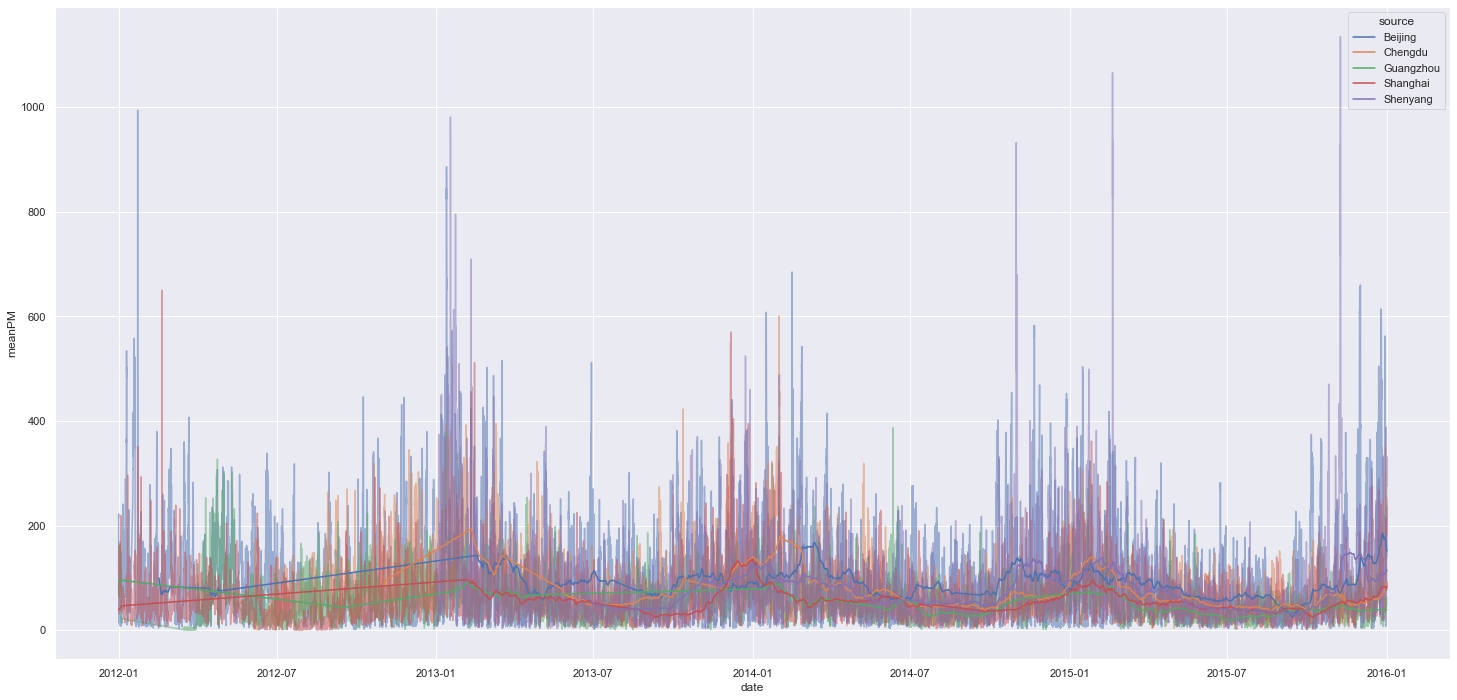

In [5]:
sns.lineplot(data = df, x = 'date', y = 'meanPM', hue = 'source', alpha = 0.5)
sns.lineplot(df.date, df.meanPM.rolling(24*30).mean(), hue = df.source, alpha = 1, color = 'red', legend=False)

### Removed 24h seasonality

<AxesSubplot:xlabel='date', ylabel='meanPM'>

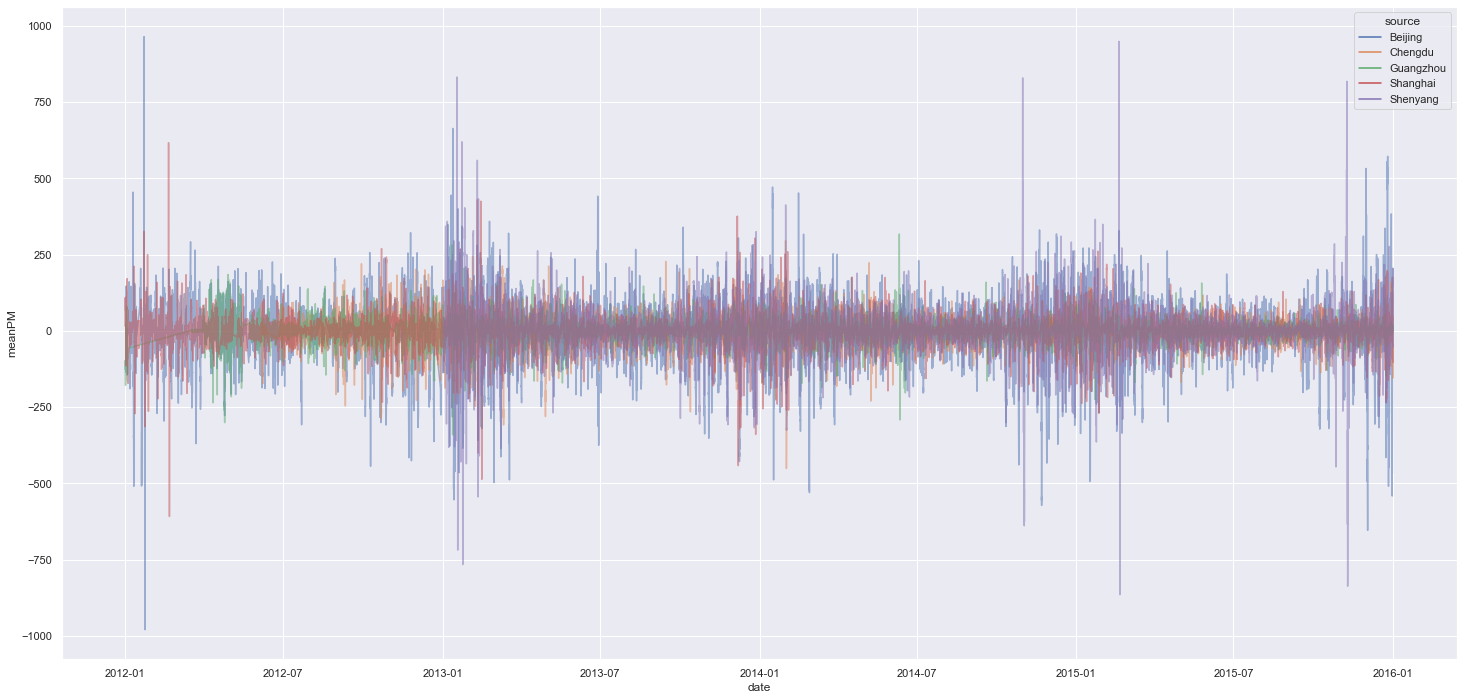

In [6]:
sns.lineplot(df.date, (df.meanPM - df.meanPM.shift(24)), hue = df.source, alpha = 0.5)

### Exploring the seasonality

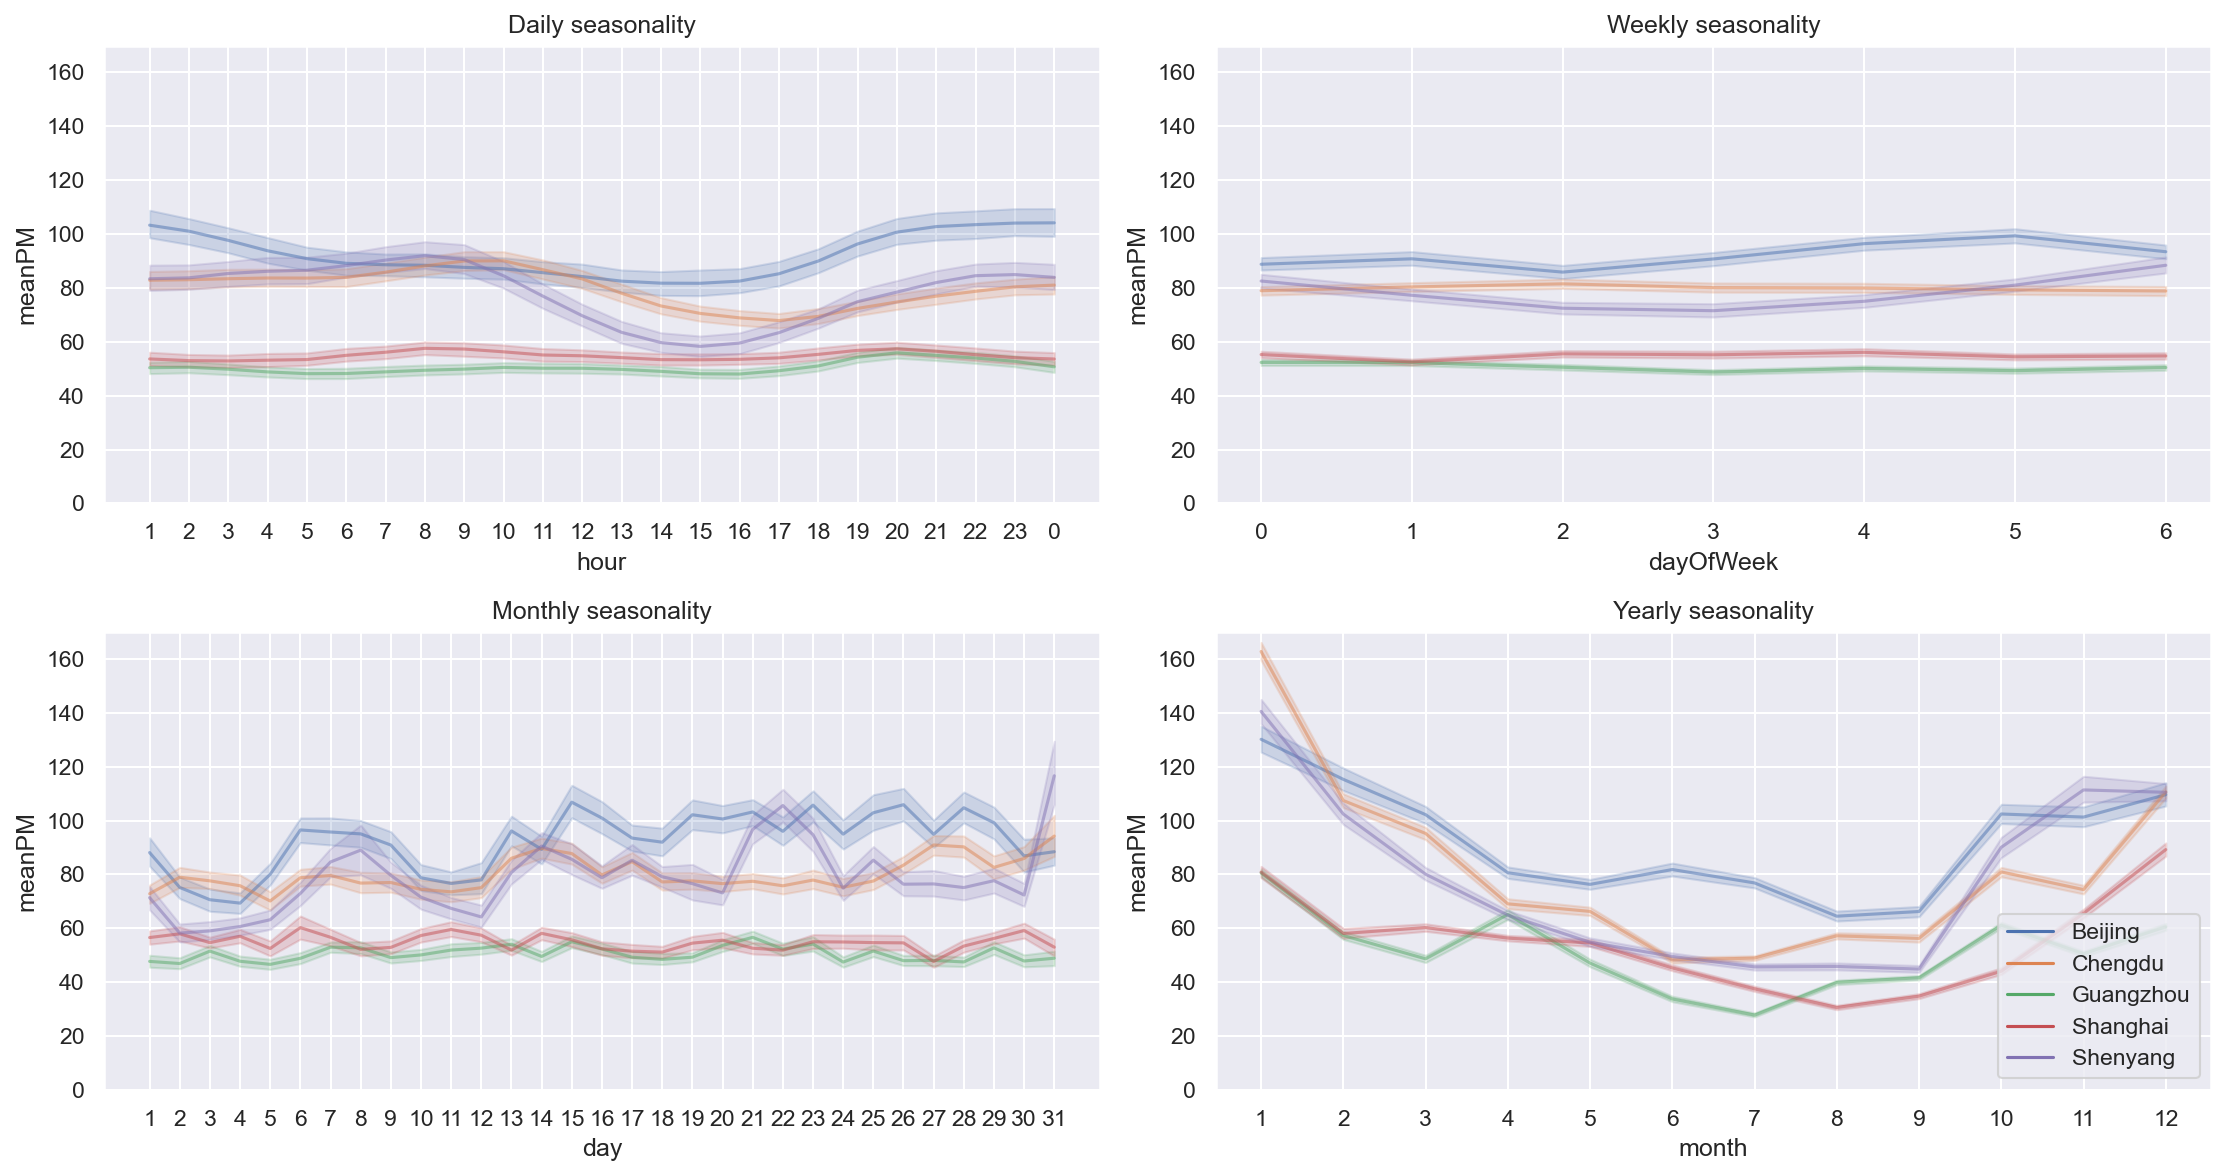

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8), dpi = 150)

seasonality = {
    'hour'      : 'Daily seasonality',
    'dayOfWeek' : 'Weekly seasonality',
    'day'       : 'Monthly seasonality',
    'month'     : 'Yearly seasonality', 
}

for i, (col, title) in enumerate(seasonality.items()):
    sns.lineplot(data = df, x = col, y = 'meanPM', hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title, ylim = (0, 170))
        
handles, labels = axs[1, 1].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))

# Independent variables

In [8]:
df.describe()

,meanPM,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,dayOfWeek
count,158144.000000,175314.000000,174795.000000,174465.000000,174452.000000,174797.000000,174790.000000,167445.000000,175315.000000
mean,70.776998,2.491393,8.657545,67.310812,1013.425461,15.801814,20.813315,6.100517,2.997861
std,65.278602,1.117070,49.525877,53.048092,9.904017,11.228380,44.551391,2443.765668,2.000482
min,1.000000,1.000000,-9999.000000,-9999.000000,975.000000,-28.000000,0.000000,0.000000,0.000000
25%,29.000000,1.000000,1.000000,52.980000,1006.000000,8.000000,2.000000,0.000000,1.000000
50%,51.750000,2.000000,12.000000,71.660000,1013.000000,18.000000,5.100000,0.000000,3.000000
75%,89.670000,3.000000,19.000000,86.890000,1021.000000,24.400000,18.000000,0.000000,5.000000
max,1134.670000,4.000000,28.000000,100.000000,1046.000000,42.000000,691.000000,999990.000000,6.000000


In [10]:
df.DEWP          = df.DEWP.replace(-9999, np.nan)
df.DEWP          = df.DEWP.replace(-97, np.nan)

df.HUMI          = df.HUMI.replace(-9999, np.nan)
df.precipitation = df.precipitation.replace(999990, np.nan)

In [11]:
df.describe()

,meanPM,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,dayOfWeek
count,158144.000000,175314.000000,174790.000000,174461.000000,174452.000000,174797.000000,174790.000000,167444.000000,175315.000000
mean,70.776998,2.491393,8.887171,67.541610,1013.425461,15.801814,20.813315,0.128467,2.997861
std,65.278602,1.117070,12.680158,22.154323,9.904017,11.228380,44.551391,1.171568,2.000482
min,1.000000,1.000000,-40.000000,0.000000,975.000000,-28.000000,0.000000,0.000000,0.000000
25%,29.000000,1.000000,1.000000,52.980000,1006.000000,8.000000,2.000000,0.000000,1.000000
50%,51.750000,2.000000,12.000000,71.660000,1013.000000,18.000000,5.100000,0.000000,3.000000
75%,89.670000,3.000000,19.000000,86.890000,1021.000000,24.400000,18.000000,0.000000,5.000000
max,1134.670000,4.000000,28.000000,100.000000,1046.000000,42.000000,691.000000,90.400002,6.000000


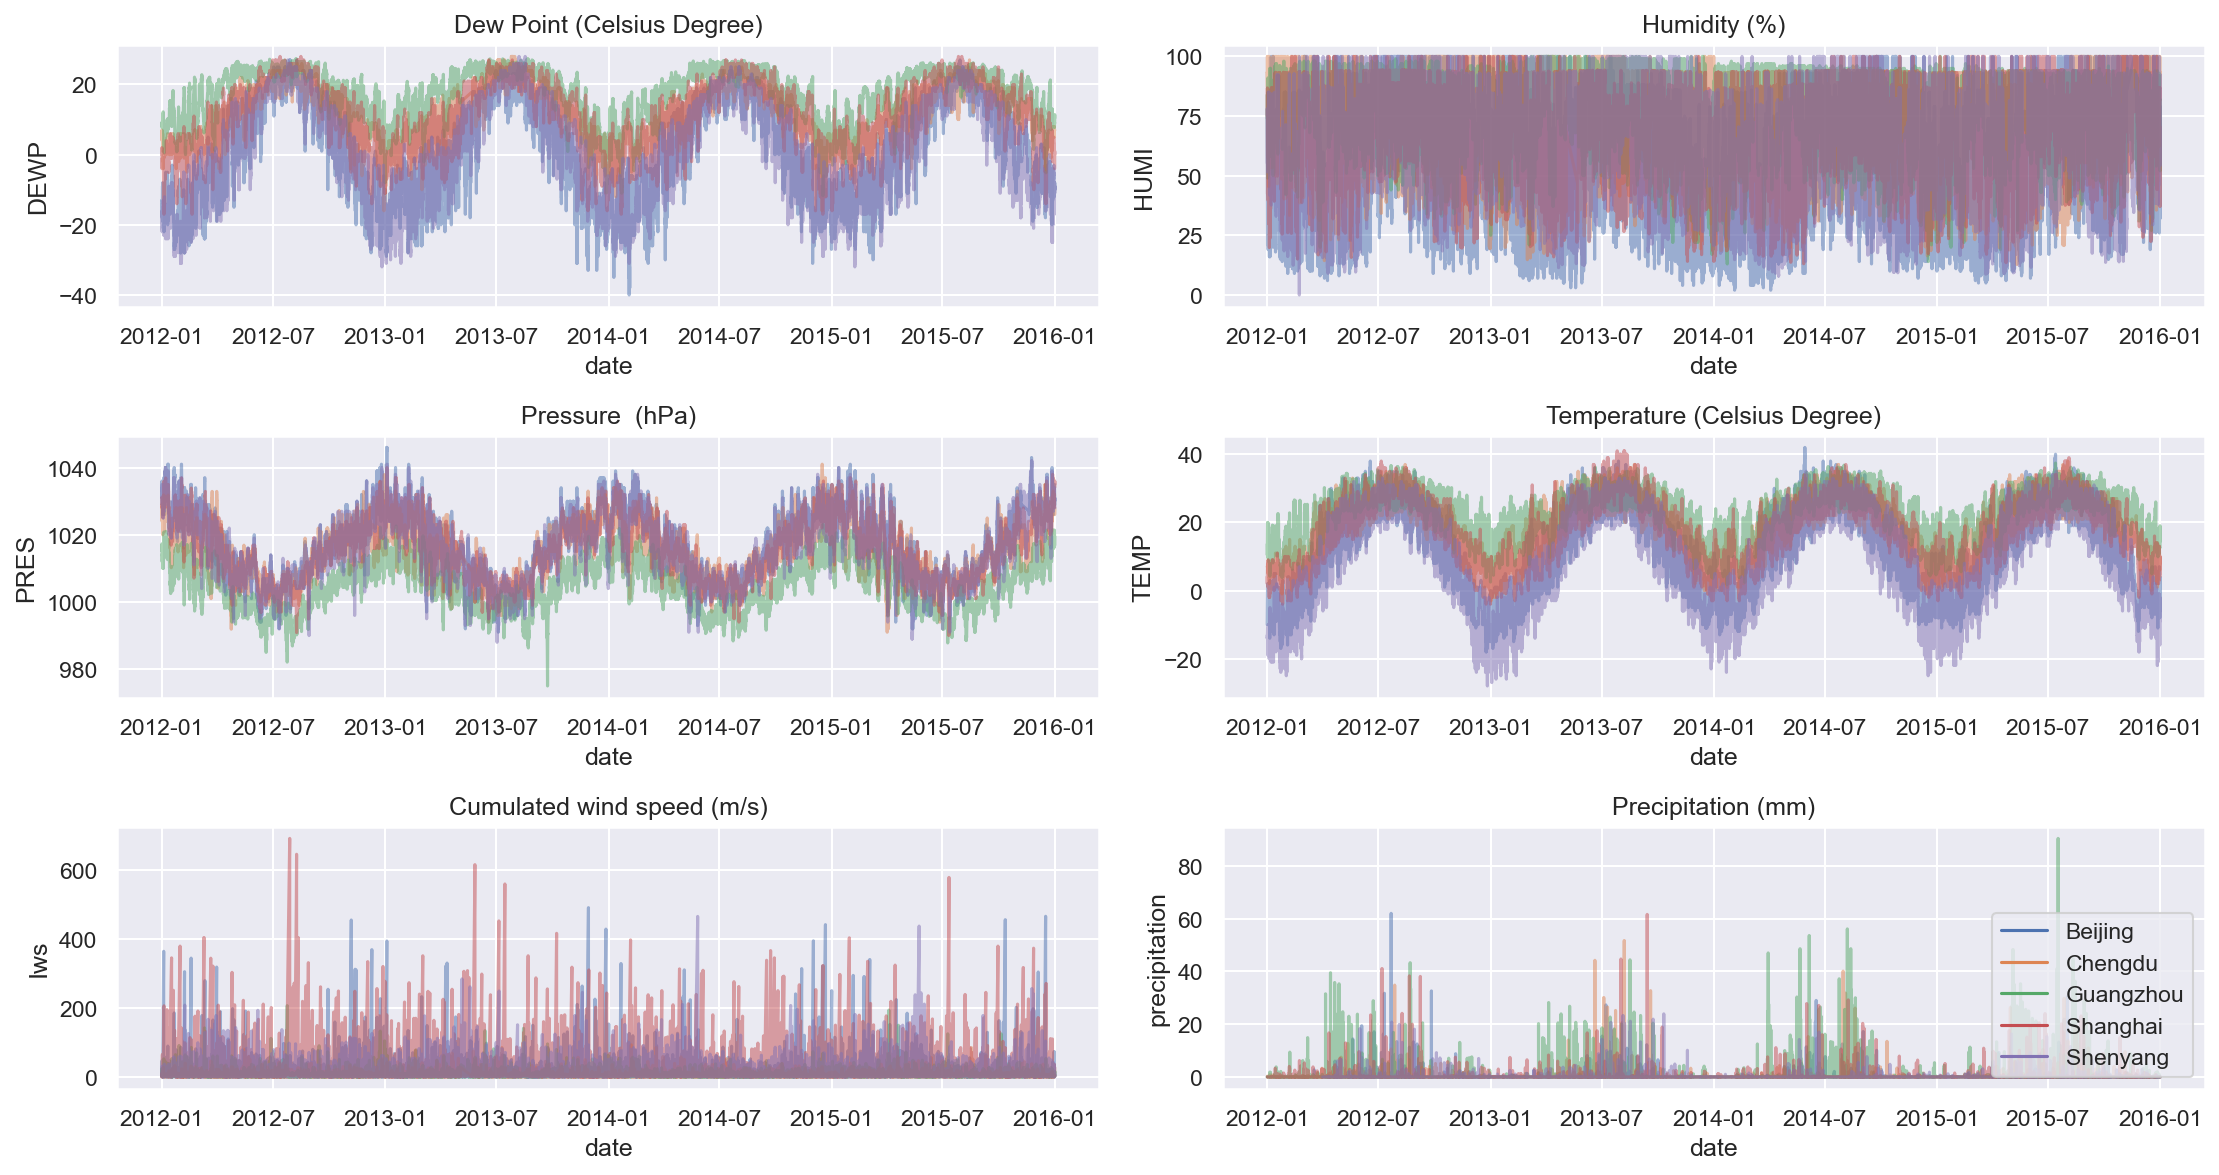

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 8), dpi = 150)

independentVariables = {
    'DEWP'           : 'Dew Point (Celsius Degree)',
    'HUMI'           : 'Humidity (%)',
    'PRES'           : 'Pressure  (hPa)', 
    'TEMP'           : 'Temperature (Celsius Degree)', 
    'Iws'            : 'Cumulated wind speed (m/s)', 
    'precipitation'  : 'Precipitation (mm)',
}

for i, (col, title) in enumerate(independentVariables.items()):
    sns.lineplot(data = df, x = 'date', y = col, hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title)
    
handles, labels = axs[0, 0].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))


### Correlation

<AxesSubplot:>

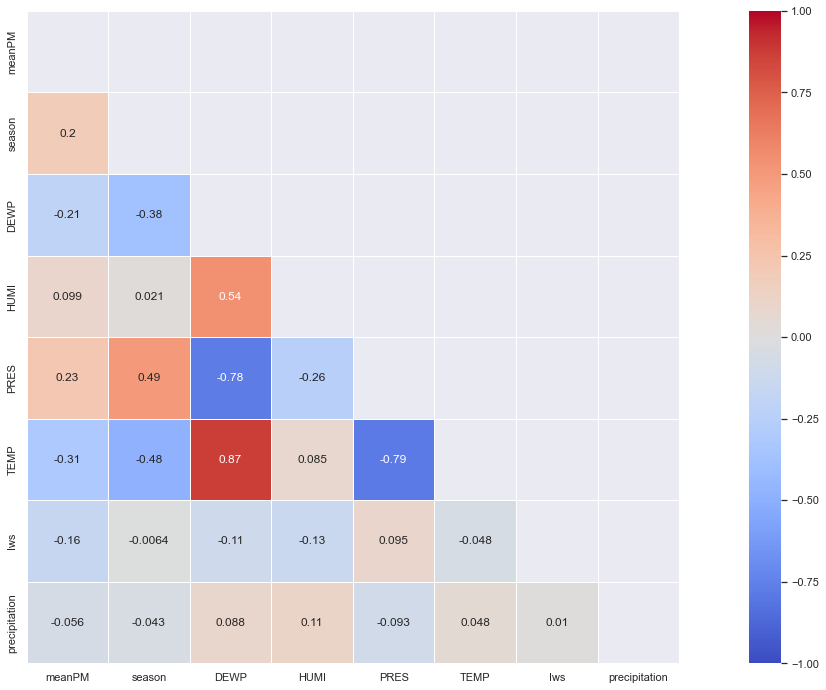

In [22]:
corr = df.drop(columns = ['dayOfWeek']).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, center=0, annot = True, square = True, linewidths = 0.5, cmap = 'coolwarm')